In [25]:
import os
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from cmcrameri import cm

In [26]:
import sys
sys.path.append("../src/")

from prediction import (
    predict_1d
)

In [27]:
folder_misc = "../../multiscale-personalized-models/misc/"

In [28]:
with open(os.path.join(folder_misc, "palette-okabe-ito.json")) as f:
    palette = json.loads(f.read())
    palette["groups"] = {int(k): v for k, v in palette["groups"].items()}

In [29]:
with open(os.path.join(folder_misc, "name_maps.json")) as f:
    name_maps = json.loads(f.read())

In [30]:
plt.style.use(os.path.join(folder_misc, "paper.mplstyle"))

In [31]:
from matplotlib.colors import ListedColormap


def create_cmap(color, n_colors=256):
    
    colors = np.ones((n_colors, 4))
    ones = np.ones(len(color))
    color = np.asarray(color)

    for i in range(n_colors):
        α = i / n_colors
        c = α * color + (1 - α) * ones
        colors[i, :-1] = c

    cmap = ListedColormap(colors)
    
    return cmap

In [32]:
traj = pd.read_csv("../data/traj.csv")
image = np.load("../data/image.npy")
A = np.load("../data/A.npy")

In [33]:
traj.t -= traj.t.min()

In [34]:
traj.head()

,x,y,z,t,pred,i
0,61661.875502,134296.655761,57883.138260,0,0,1
1,61895.245035,133642.625806,55568.056865,10,0,1
2,62502.707049,132745.201293,53022.983638,20,0,1
3,62863.222550,131473.286796,50947.133795,30,0,1
4,63084.263229,129954.971787,49934.379416,40,0,1


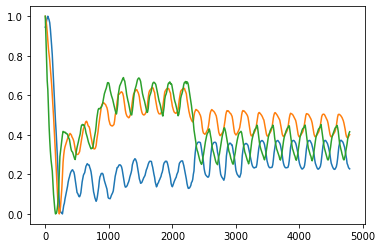

In [35]:
for c in "xyz":
    x = traj[c]
    x = (x - x.min()) / np.ptp(x)
    plt.plot(traj.t, x)

In [36]:
image /= image.max()

In [37]:
pred = predict_1d(A)

starts = np.nonzero(np.diff(pred) > 0)[0]
ends = np.nonzero(np.diff(pred) < 0)[0]

if starts[0] > ends[0]:
    starts = np.hstack([0, starts])

In [42]:
colors = palette["okabe_ito"]
color_proba = colors[5]
cmap_proba = create_cmap(color_proba)
vmin = 0
vmax = 2

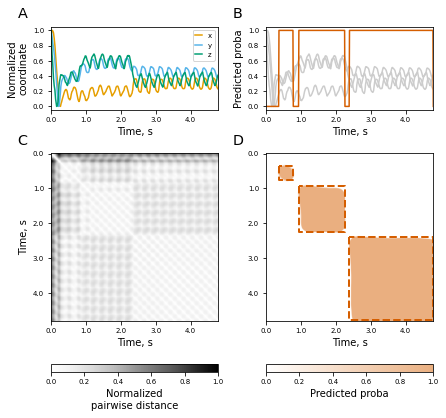

In [44]:
height_percents = [0.03, 0.6, 0.3]
height_percents = np.array(height_percents) / np.sum(height_percents)
space_w = 0.1
space_h = 0.1

width = (1 - space_w * 3) / 2
heights = [(1 - space_h * 4) * h for h in height_percents]

aspect = heights[1] / width

fig_height = 6
fig_width = fig_height * aspect

fig = plt.figure(
    figsize=(fig_width, fig_height),
    # facecolor="aliceblue"
)

bottom = space_h

for i in range(len(heights)):
    axes_row = []
    for j in range(2):
        
        left = space_w + (width + space_w) * j
        width = width
        
        height = heights[i]
        
        pos = [left, bottom, width, height]
        plt.axes(pos)
                
    bottom += height + space_h

axes = np.array(fig.axes).reshape(-1, 2)

######################

plt.sca(axes[2, 0])
for c, color in zip("xyz", colors):
    x = traj[c]
    x = (x - x.min()) / np.ptp(x)
    plt.plot(traj.t, x, label=c, color=color)
plt.legend(
    loc="upper right",
    ncol=1,
    fontsize="x-small",
    handlelength=1
)
plt.ylabel("Normalized\ncoordinate")
    
plt.sca(axes[2, 1])
for c in "xyz":
    x = traj[c]
    x = (x - x.min()) / np.ptp(x)
    plt.plot(traj.t, x, color="0.8")
plt.plot(traj.t, pred, color=color_proba)
plt.ylabel("Predicted proba")

t_max = traj.t.max()

for ax in axes[2].flatten():
    plt.sca(ax)
    plt.xticks(
        np.arange(0, t_max, 1000),
        np.arange(0, t_max, 1000) / 1000,
        # size="x-small"
    )
    plt.xlim(traj.t.min(), traj.t.max())
    plt.xlabel("Time, s")
      
ims = axes[1, 1].imshow(A, cmap=cmap_proba, vmin=vmin, vmax=vmax)
plt.colorbar(
    ims,
    cax=axes[0, 1],
    orientation="horizontal",
    ticks=np.linspace(0, 1, 6),
) 

plt.sca(axes[1, 1])
for i, j in zip(starts, ends):
    x = [i, i, j, j, i]
    y = [i, j, j, i, i]
    plt.plot(x, y, "--", c=color_proba, lw=2)
    # plt.plot(x, y, "--w", lw=1)

plt.sca(axes[0, 1])
plt.xlabel("Predicted proba")
plt.xlim(0, 1)
plt.xticks(np.linspace(0, 1, 6), size="x-small")


ims = axes[1, 0].imshow(image, cmap="Greys")
plt.colorbar(
    ims,
    cax=axes[0, 0],
    orientation="horizontal",
    ticks=np.linspace(0, 1, 6),
) 

plt.sca(axes[0, 0])
plt.xlabel("Normalized\npairwise distance")
plt.xlim(0, 1)
plt.xticks(np.linspace(0, 1, 6), size="x-small")

for ax in axes[1].flatten():
    plt.sca(ax)
    plt.xticks(
        np.arange(0, len(A), 100),
        np.arange(0, len(A), 100) / 100,
        size="x-small"
    )
    plt.yticks(
        np.arange(0, len(A), 100),
        np.arange(0, len(A), 100) / 100,
        size="x-small"
    )
    plt.xlabel("Time, s")
    
plt.sca(axes[1, 0])
plt.ylabel("Time, s")


letters = "ABCD"
for ax, letter in zip(axes[1:][::-1].flatten(), letters):
    ax.tick_params(axis="x", labelsize="x-small")
    ax.tick_params(axis="y", labelsize="x-small")
    
    letter_margin_x = 0.07
    letter_margin_y = 0.02
    letter_params = dict(
        weight="normal",
        size="x-large"
    )
    
    pos = ax.get_position()

    fig.text(
        pos.xmin - letter_margin_x,
        pos.ymax + letter_margin_y,
        letter,
        **letter_params
    )

plt.savefig(
    "../images/illustation.png",
    facecolor="white",
    bbox_inches="tight",
    dpi=300
)

# Prediction errors

In [13]:
def random_hole(r=10, R=100):
    i, j = np.random.randint(R - r, size=2)
    mask = np.ones((R, R))
    mask[i: i+r, j: j+r] = 0
    return mask

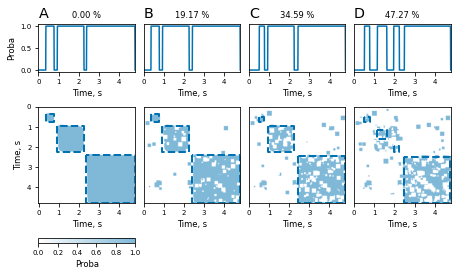

In [22]:
filename_load = "../data/A.npy"
# filename_load = "../data/A_synthetic.npy"
A = np.load(filename_load)
A_copy = A.copy()
np.random.seed(42)

severity = 2
size = np.array((5, 25)) * 1


height_percents = [0.03, 0.6, 0.3]
height_percents = np.array(height_percents) / np.sum(height_percents)
space_w = 0.02
space_h = 0.12

ncols = 4

width = (1 - space_w * (ncols + 1)) / ncols
heights = [(1 - space_h * 4) * h for h in height_percents]

aspect = heights[1] / width

fig_height = 4
fig_width = fig_height * aspect

fig = plt.figure(
    figsize=(fig_width, fig_height),
    # facecolor="aliceblue",
)

bottom = space_h

for i in range(len(heights)):
    axes_row = []
    for j in range(ncols):
        
        left = space_w + (width + space_w) * j
        width = width
        
        height = heights[i]
        
        pos = [left, bottom, width, height]
        
        # if i == 0 and j == 0:
        #     continue
            
        plt.axes(pos)
                
    bottom += height + space_h

axes = np.array(fig.axes).reshape(-1, ncols)


for i_col, axes_col in enumerate(axes.T):
    
    if i_col:
        
        axes_col[0].remove()
    
        for _ in range(severity * 100):
            mask = random_hole(
                r=np.random.randint(*size),
                R=len(A)
            )
            A = A * mask

        for _ in range(severity * 10):
            mask = random_hole(
                r=np.random.randint(*size),
                R=len(A)
            )
            A = np.clip(A + (1 - mask), 0, 1)
            
    misclassified_ratio = (A != A_copy).mean() * 100
    title = f"{misclassified_ratio:.2f} %"
    axes_col[2].set_title(title, size="small")
            
            
    pred = predict_1d(A)
    t = np.arange(len(pred)) / 100
    
    starts = np.nonzero(np.diff(pred) > 0)[0]
    ends = np.nonzero(np.diff(pred) < 0)[0]

    if starts[0] > ends[0]:
        starts = np.hstack([0, starts])
        
    plt.sca(axes_col[1])
    ims = plt.imshow(A, cmap=cmap_proba, vmin=vmin, vmax=vmax)
    for i, j in zip(starts, ends):
        x = [i, i, j, j, i]
        y = [i, j, j, i, i]
        plt.plot(x, y, "--", c=color_proba, lw=2)
    
    if i_col == 0:
        
        plt.colorbar(
            ims,
            cax=axes_col[0],
            orientation="horizontal",
            ticks=np.linspace(0, 1, 6),
        ) 
            
        plt.sca(axes_col[0])
        plt.xlabel("Proba", size="small")
        plt.xlim(0, 1)
        plt.xticks(np.linspace(0, 1, 6), size="x-small")
        
        plt.sca(axes_col[1])
        plt.xticks(
            np.arange(0, len(A), 100),
            (np.arange(0, len(A), 100) / 100).astype(int),
            size="x-small"
        )
        plt.yticks(
            np.arange(0, len(A), 100),
            (np.arange(0, len(A), 100) / 100).astype(int),
            size="x-small"
        )
        plt.xlabel("Time, s", size="small")
        plt.ylabel("Time, s", size="small")
        
        plt.sca(axes_col[2])
        plt.ylabel("Proba", size="small")
        
        
    else:
        
        plt.sca(axes_col[2])
        # plt.xticks([])
        plt.yticks([])
        
        plt.sca(axes_col[1])
        plt.yticks([])
        plt.xticks(
            np.arange(0, len(A), 100),
            (np.arange(0, len(A), 100) / 100).astype(int),
            size="x-small"
        )
        plt.xlabel("Time, s", size="small")
        
    
    plt.sca(axes_col[2])
    plt.plot(t, pred, color=color_proba)
    plt.xticks(
        np.arange(0, len(A), 1),
        size="x-small"
    )
    plt.xlim(t[0], t[-1])
    
    
    
for ax in axes[2].flatten():
    plt.sca(ax)
    plt.xlabel("Time, s", size="small")
    
    
letters = "ABCD"
for ax, letter in zip(axes[2].flatten(), letters):
    
    letter_margin_x = 0.0
    letter_margin_y = 0.02
    letter_params = dict(
        weight="normal",
        size="x-large"
    )
    
    pos = ax.get_position()

    fig.text(
        pos.xmin - letter_margin_x,
        pos.ymax + letter_margin_y,
        letter,
        **letter_params
    )
    

for ax in axes.flatten():
    ax.tick_params(axis="x", labelsize="x-small")
    ax.tick_params(axis="y", labelsize="x-small")
    
    
# plt.savefig(
#     "../images/prediction-errors.png",
#     facecolor="white",
#     bbox_inches="tight",
#     dpi=300
# )